# LME銅3Mアウトライト価格可視化分析

## 分析目的
このノートブックは、LME銅3Mアウトライト価格（CMCU3）の包括的な可視化分析を行います：
1. **価格トレンド分析**: 長期・短期の価格動向
2. **ボラティリティ分析**: 価格変動の特性
3. **出来高分析**: 取引活動と価格の関係
4. **テクニカル分析**: 移動平均、ボリンジャーバンド等
5. **季節性分析**: 年間・月間パターン
6. **リスク指標**: VaR、最大ドローダウン等

## データ概要
- **期間**: 2022年7月〜2025年7月（約3年間）
- **頻度**: 日次データ
- **価格範囲**: $7,170 - $10,889 per tonne
- **通貨**: USD
- **出来高**: 平均約19,377ロット/日

In [1]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
from scipy import stats

# Try to import optional packages
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
    print("✓ Plotly available for interactive charts")
except ImportError:
    print("Plotly not available. Using matplotlib for all visualizations.")
    PLOTLY_AVAILABLE = False

try:
    import mplfinance as mpf
    MPF_AVAILABLE = True
    print("✓ mplfinance available for candlestick charts")
except ImportError:
    print("mplfinance not available. Using matplotlib for price charts.")
    MPF_AVAILABLE = False

warnings.filterwarnings('ignore')
load_dotenv()

# データベース設定
db_config = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'database': os.getenv('DB_NAME', 'lme_copper_db'),
    'user': os.getenv('DB_USER', 'postgres'),
    'password': os.getenv('DB_PASSWORD', 'password'),
    'port': os.getenv('DB_PORT', '5432')
}

# Create connection string
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"

# スタイル設定
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = [15, 10]

print("✓ ライブラリ読み込み完了")
print("Ready for LME 3M outright analysis")

✓ Plotly available for interactive charts
mplfinance not available. Using matplotlib for price charts.
✓ ライブラリ読み込み完了
Ready for LME 3M outright analysis


## データ読み込みと前処理

In [2]:
def load_3m_outright_data():
    """LME銅3Mアウトライトデータを読み込み"""
    try:
        engine = create_engine(connection_string)
        
        query = """
        SELECT 
            trade_date,
            ric,
            last_price as close_price,
            high_price,
            low_price,
            open_price,
            volume,
            currency
        FROM lme_copper_prices
        WHERE price_type = '3M_OUTRIGHT'
        AND last_price IS NOT NULL
        ORDER BY trade_date
        """
        
        df = pd.read_sql_query(query, engine)
        engine.dispose()
        
        # データ前処理
        df['trade_date'] = pd.to_datetime(df['trade_date'])
        df.set_index('trade_date', inplace=True)
        
        # 数値型に変換
        price_columns = ['close_price', 'high_price', 'low_price', 'open_price']
        for col in price_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        df['volume'] = pd.to_numeric(df['volume'], errors='coerce')
        
        # 基本統計情報
        print(f"データ読み込み完了: {len(df):,}件のレコード")
        print(f"期間: {df.index.min().date()} ～ {df.index.max().date()}")
        print(f"RIC: {df['ric'].iloc[0]}")
        print(f"通貨: {df['currency'].iloc[0]}")
        
        return df
    
    except Exception as e:
        print(f"データ読み込みエラー: {e}")
        return None

# データ読み込み
copper_3m = load_3m_outright_data()

if copper_3m is not None:
    print(f"\n基本統計:")
    print(f"平均価格: ${copper_3m['close_price'].mean():,.2f}")
    print(f"最高価格: ${copper_3m['high_price'].max():,.2f}")
    print(f"最安価格: ${copper_3m['low_price'].min():,.2f}")
    print(f"平均出来高: {copper_3m['volume'].mean():,.0f} ロット")
    print(f"最大出来高: {copper_3m['volume'].max():,.0f} ロット")
    
    # データ品質チェック
    missing_prices = copper_3m['close_price'].isna().sum()
    missing_volume = copper_3m['volume'].isna().sum()
    print(f"\nデータ品質:")
    print(f"価格欠損: {missing_prices}件")
    print(f"出来高欠損: {missing_volume}件")
    
    # 最新5日間のデータ確認
    print(f"\n最新データ:")
    print(copper_3m[['close_price', 'volume']].tail())

データ読み込み完了: 758件のレコード
期間: 2022-07-06 ～ 2025-07-04
RIC: CMCU3
通貨: USD

基本統計:
平均価格: $8,821.82
最高価格: $11,104.50
最安価格: $6,955.00
平均出来高: 19,377 ロット
最大出来高: 69,434 ロット

データ品質:
価格欠損: 0件
出来高欠損: 0件

最新データ:
            close_price  volume
trade_date                     
2025-06-30       9869.0   13875
2025-07-01       9934.0   22572
2025-07-02      10013.0   17008
2025-07-03       9954.5   13628
2025-07-04       9864.0   12845


## 1. 基本的な価格チャート

### 解釈ガイド:
- **長期トレンド**: 全期間を通じた価格方向性
- **ボラティリティ**: 価格変動の激しさ
- **サポート/レジスタンス**: 重要な価格水準
- **出来高**: 価格変動の信頼性を示す

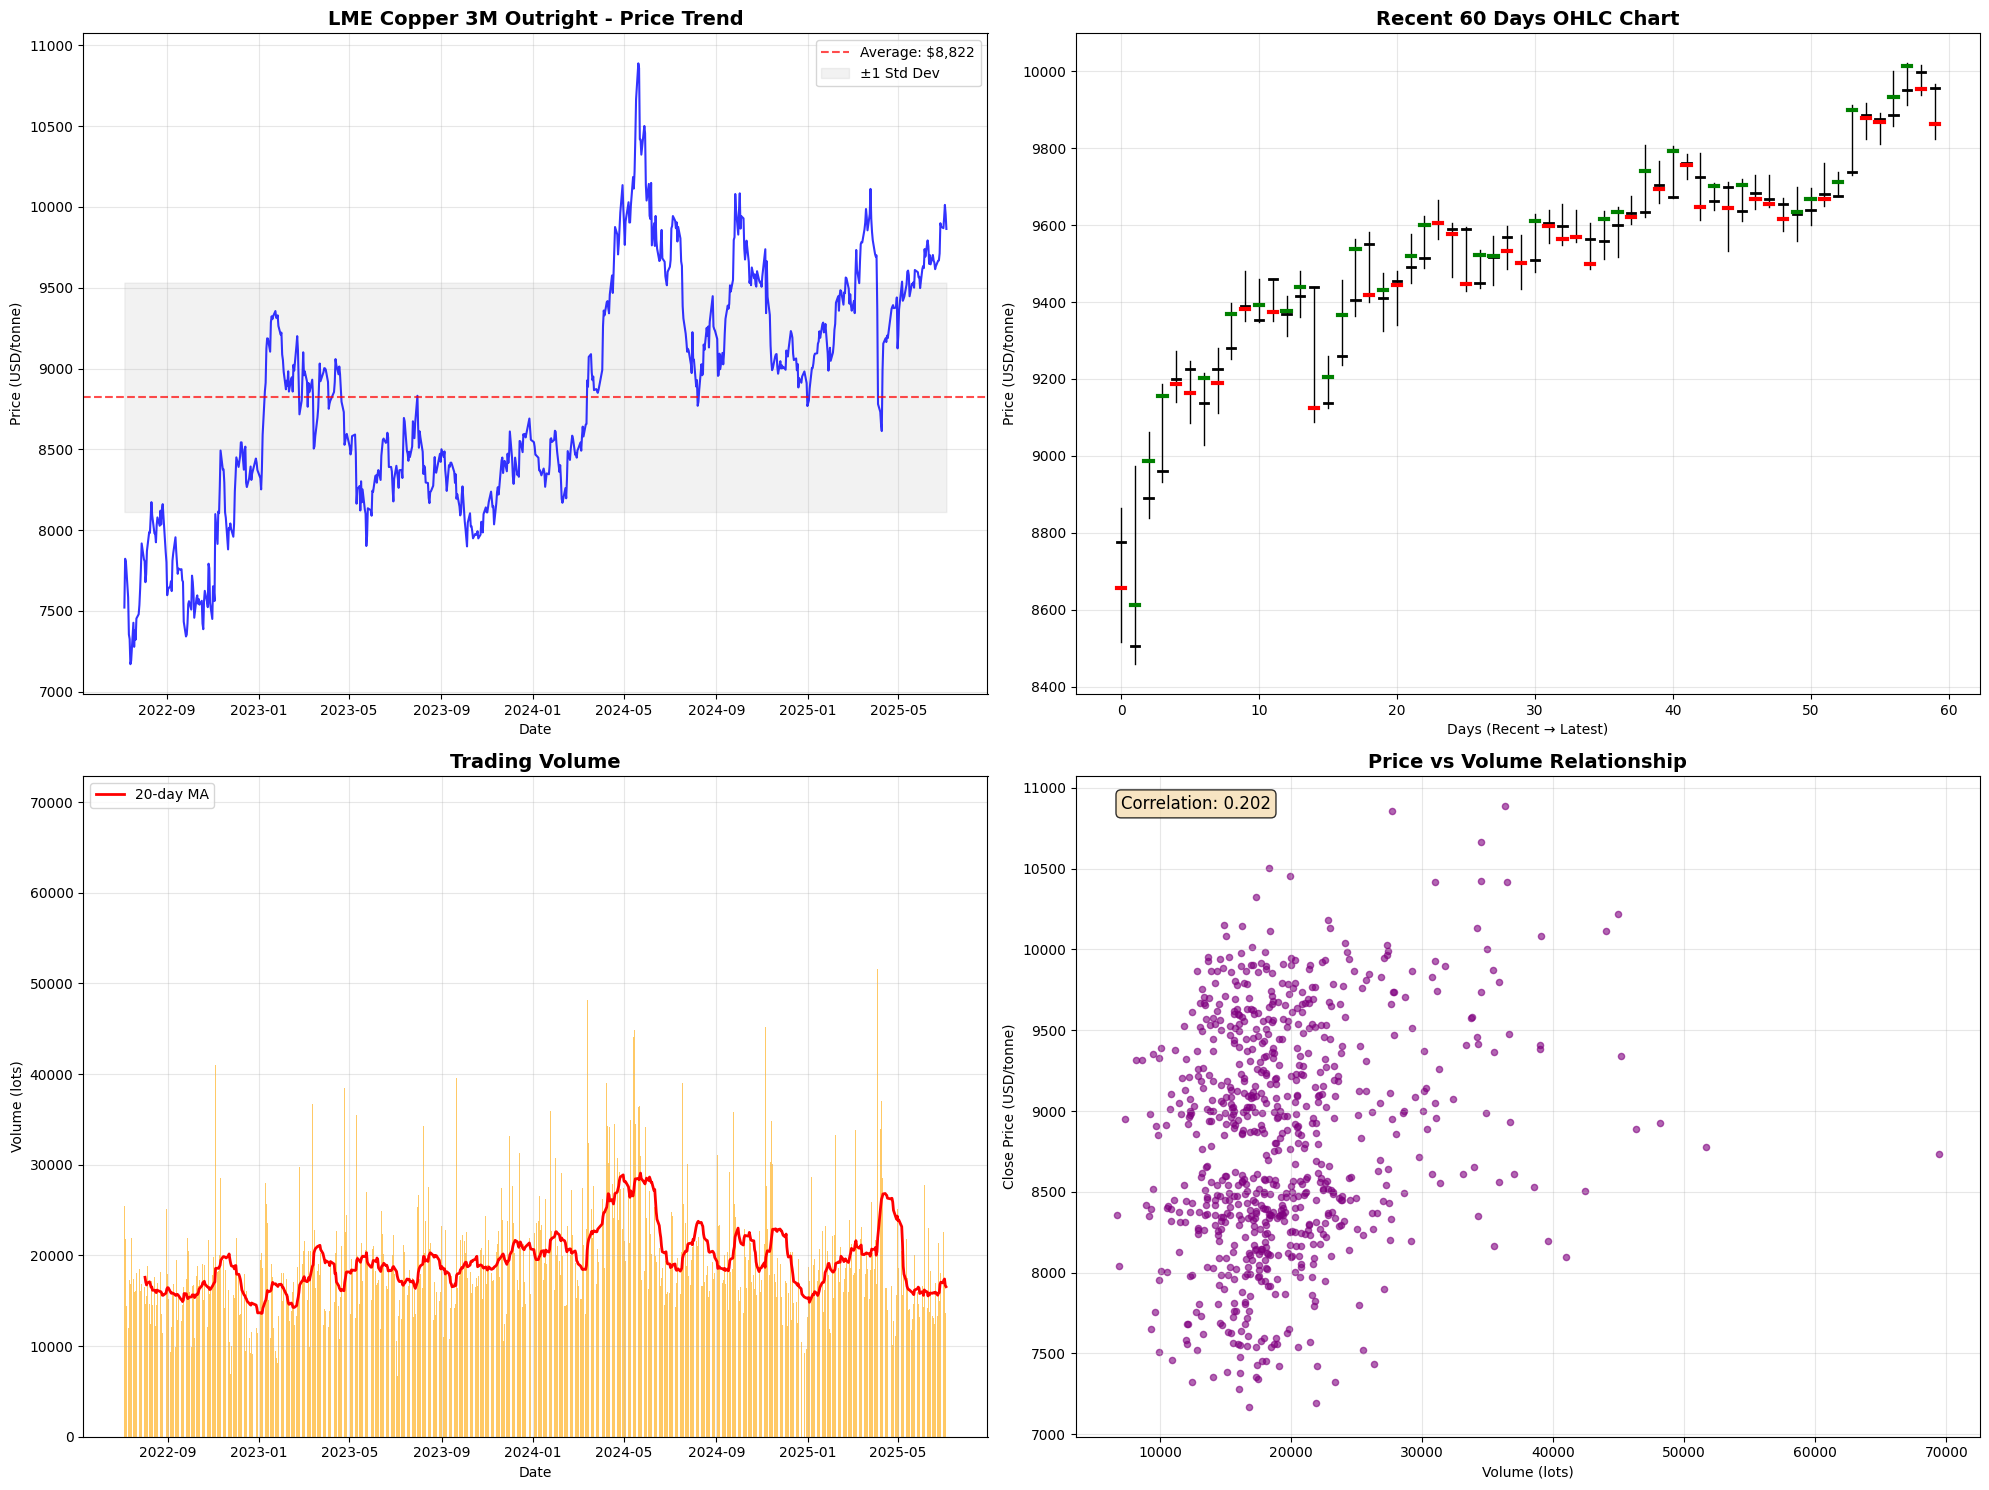

In [3]:
# 基本価格チャートの作成
if copper_3m is not None:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. 終値時系列チャート
    ax1.plot(copper_3m.index, copper_3m['close_price'], linewidth=1.5, color='blue', alpha=0.8)
    ax1.set_title('LME Copper 3M Outright - Price Trend', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price (USD/tonne)')
    ax1.grid(True, alpha=0.3)
    
    # 価格レンジの塗りつぶし
    price_mean = copper_3m['close_price'].mean()
    price_std = copper_3m['close_price'].std()
    ax1.axhline(y=price_mean, color='red', linestyle='--', alpha=0.7, label=f'Average: ${price_mean:,.0f}')
    ax1.fill_between(copper_3m.index, price_mean - price_std, price_mean + price_std, 
                     alpha=0.1, color='gray', label='±1 Std Dev')
    ax1.legend()
    
    # 2. OHLC バーチャート（簡易版）
    recent_data = copper_3m.tail(60)  # 直近60日
    for i, (date, row) in enumerate(recent_data.iterrows()):
        color = 'green' if row['close_price'] >= row['open_price'] else 'red'
        # High-Low line
        ax2.plot([i, i], [row['low_price'], row['high_price']], color='black', linewidth=1)
        # Open-Close bar
        ax2.plot([i-0.3, i+0.3], [row['open_price'], row['open_price']], color='black', linewidth=2)
        ax2.plot([i-0.3, i+0.3], [row['close_price'], row['close_price']], color=color, linewidth=3)
    
    ax2.set_title('Recent 60 Days OHLC Chart', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Days (Recent → Latest)')
    ax2.set_ylabel('Price (USD/tonne)')
    ax2.grid(True, alpha=0.3)
    
    # 3. 出来高チャート
    ax3.bar(copper_3m.index, copper_3m['volume'], alpha=0.6, color='orange', width=1)
    ax3.set_title('Trading Volume', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Volume (lots)')
    ax3.grid(True, alpha=0.3)
    
    # 出来高移動平均線
    volume_ma = copper_3m['volume'].rolling(20).mean()
    ax3.plot(copper_3m.index, volume_ma, color='red', linewidth=2, label='20-day MA')
    ax3.legend()
    
    # 4. 価格vs出来高散布図
    ax4.scatter(copper_3m['volume'], copper_3m['close_price'], alpha=0.6, s=20, color='purple')
    ax4.set_title('Price vs Volume Relationship', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Volume (lots)')
    ax4.set_ylabel('Close Price (USD/tonne)')
    ax4.grid(True, alpha=0.3)
    
    # 相関計算
    correlation = copper_3m['close_price'].corr(copper_3m['volume'])
    ax4.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=ax4.transAxes, fontsize=12, 
             bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('../generated_images/lme_3m_basic_charts.png', dpi=300, bbox_inches='tight')
    plt.show()

## 2. リターンとボラティリティ分析

### 解釈ガイド:
- **日次リターン**: 対数リターンによる日々の価格変化率
- **累積リターン**: 投資パフォーマンスの推移
- **ローリングボラティリティ**: 時間変化するリスク水準
- **リターン分布**: 正規分布からの乖離（歪度・尖度）

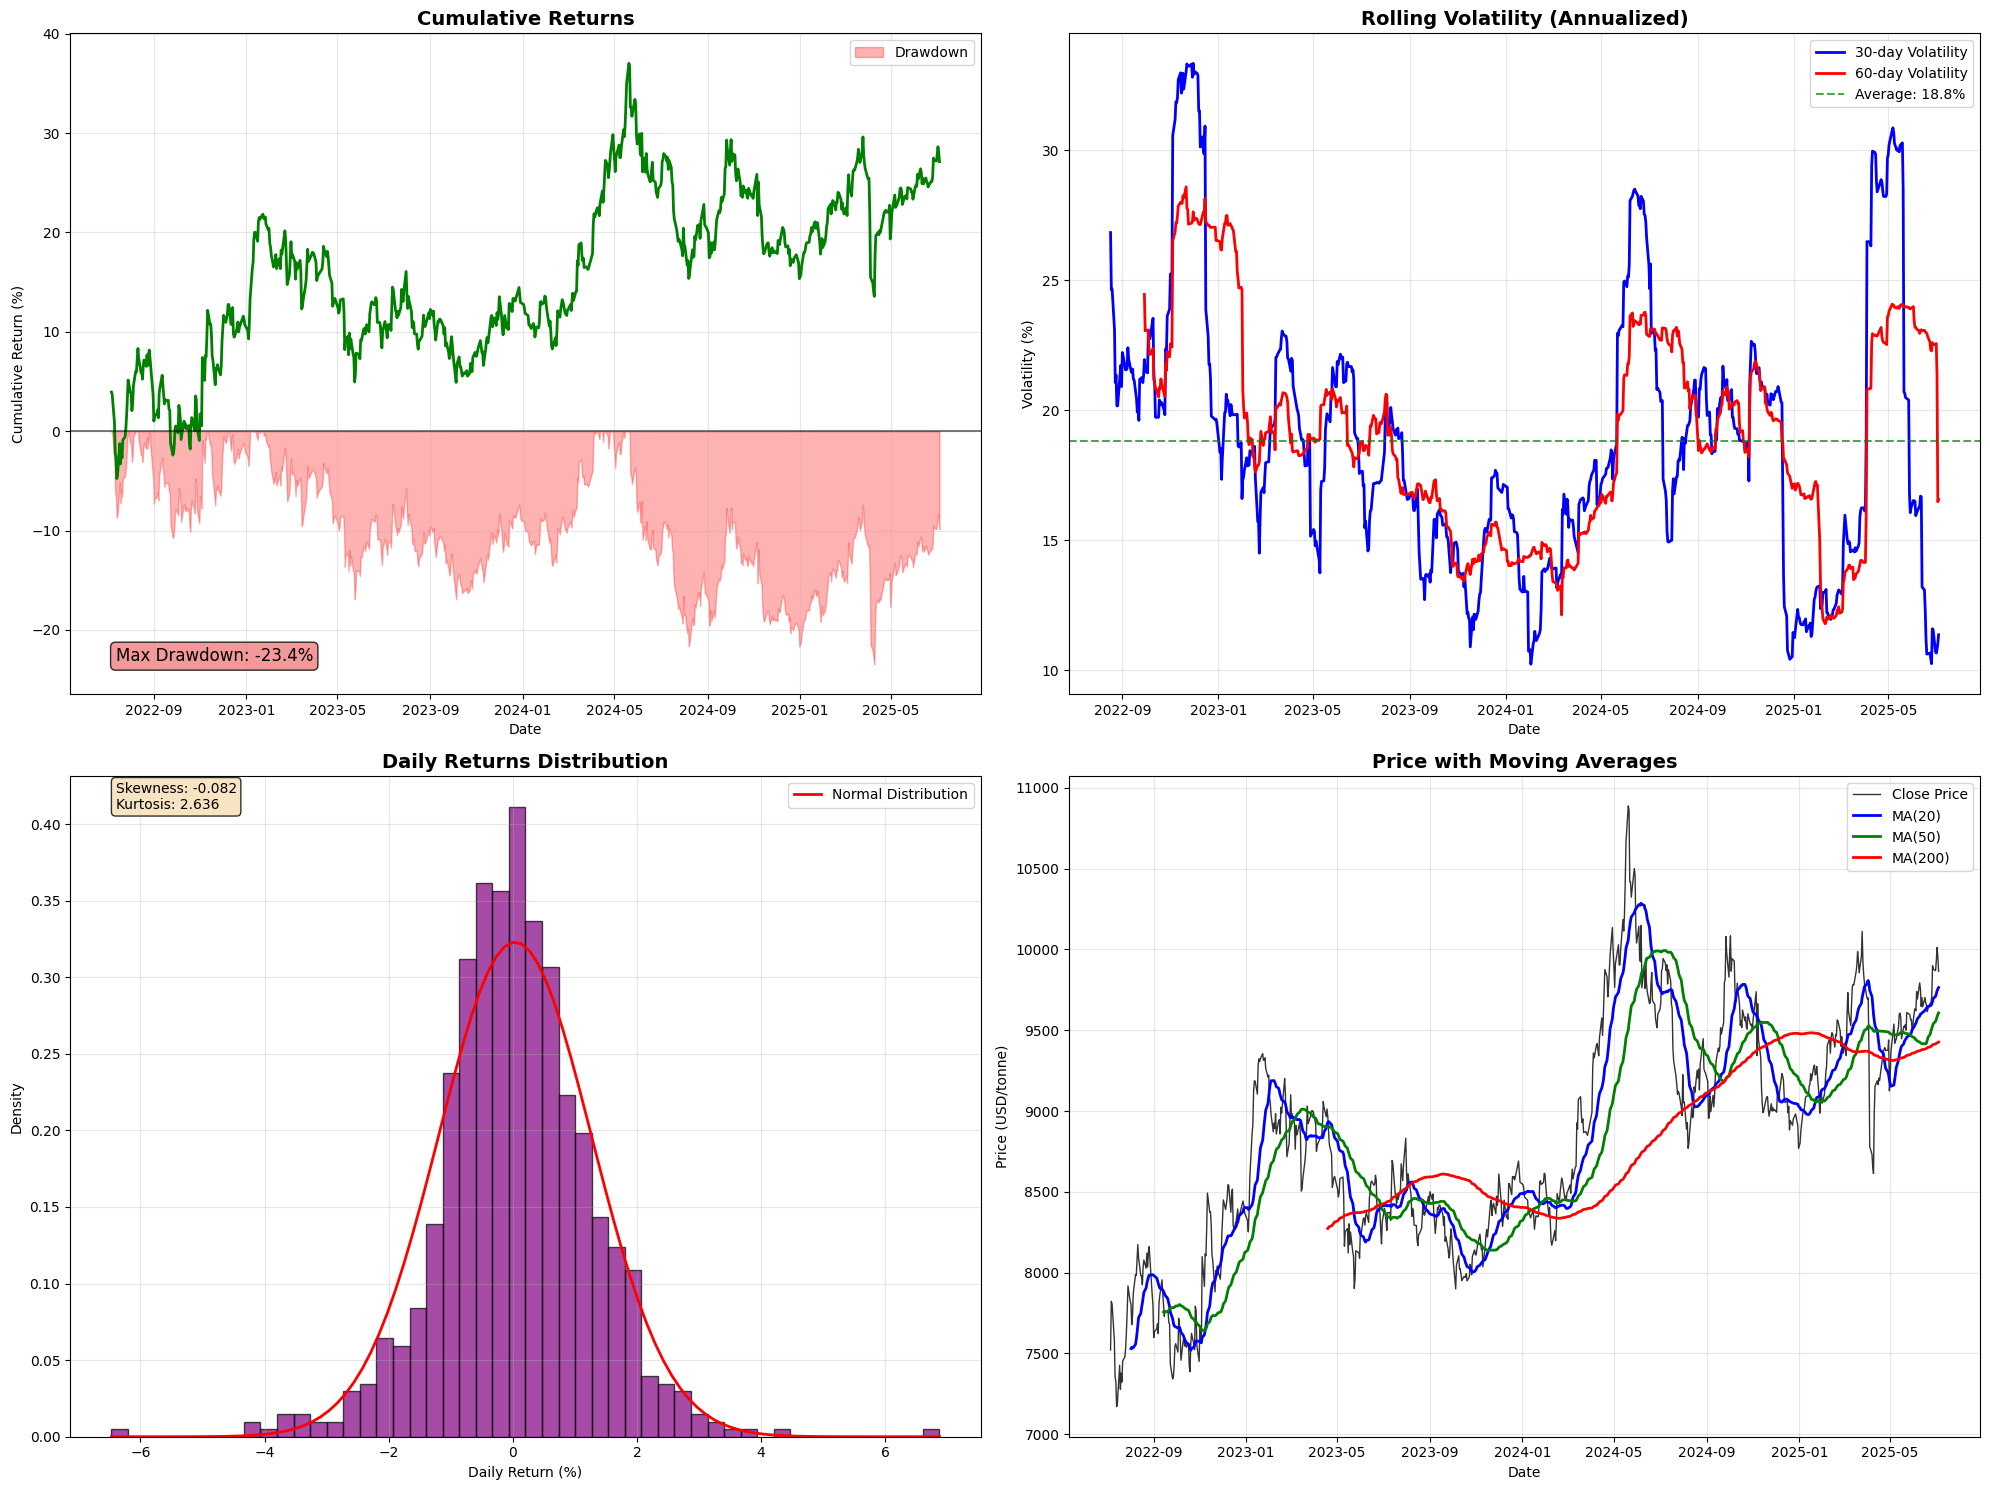


リターン・ボラティリティ統計:
年率リターン: 9.03%
年率ボラティリティ: 19.61%
シャープレシオ: 0.460
最大ドローダウン: -23.45%
勝率: 51.1%
VaR (5%): -1.97%
VaR (1%): -3.44%


In [4]:
# リターンとボラティリティの計算
if copper_3m is not None:
    # 日次リターン計算
    copper_3m['daily_return'] = np.log(copper_3m['close_price'] / copper_3m['close_price'].shift(1))
    copper_3m['cumulative_return'] = copper_3m['daily_return'].cumsum()
    
    # ローリングボラティリティ計算
    copper_3m['volatility_30d'] = copper_3m['daily_return'].rolling(30).std() * np.sqrt(252)
    copper_3m['volatility_60d'] = copper_3m['daily_return'].rolling(60).std() * np.sqrt(252)
    
    # 移動平均計算
    copper_3m['ma_20'] = copper_3m['close_price'].rolling(20).mean()
    copper_3m['ma_50'] = copper_3m['close_price'].rolling(50).mean()
    copper_3m['ma_200'] = copper_3m['close_price'].rolling(200).mean()
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. 累積リターンチャート
    ax1.plot(copper_3m.index, copper_3m['cumulative_return'] * 100, linewidth=2, color='green')
    ax1.set_title('Cumulative Returns', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative Return (%)')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # 最大ドローダウンの計算と表示
    rolling_max = copper_3m['cumulative_return'].expanding().max()
    drawdown = (copper_3m['cumulative_return'] - rolling_max) * 100
    ax1.fill_between(copper_3m.index, drawdown, 0, alpha=0.3, color='red', label='Drawdown')
    max_dd = drawdown.min()
    ax1.text(0.05, 0.05, f'Max Drawdown: {max_dd:.1f}%', 
             transform=ax1.transAxes, fontsize=12, 
             bbox=dict(boxstyle="round", facecolor='lightcoral', alpha=0.8))
    ax1.legend()
    
    # 2. ローリングボラティリティ
    ax2.plot(copper_3m.index, copper_3m['volatility_30d'] * 100, label='30-day Volatility', 
             linewidth=2, color='blue')
    ax2.plot(copper_3m.index, copper_3m['volatility_60d'] * 100, label='60-day Volatility', 
             linewidth=2, color='red')
    ax2.set_title('Rolling Volatility (Annualized)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volatility (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 平均ボラティリティライン
    avg_vol = copper_3m['volatility_30d'].mean() * 100
    ax2.axhline(y=avg_vol, color='green', linestyle='--', alpha=0.7, 
                label=f'Average: {avg_vol:.1f}%')
    ax2.legend()
    
    # 3. 日次リターン分布
    returns_clean = copper_3m['daily_return'].dropna() * 100
    ax3.hist(returns_clean, bins=50, alpha=0.7, color='purple', edgecolor='black', density=True)
    ax3.set_title('Daily Returns Distribution', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Daily Return (%)')
    ax3.set_ylabel('Density')
    ax3.grid(True, alpha=0.3)
    
    # 正規分布との比較
    mu, sigma = returns_clean.mean(), returns_clean.std()
    x = np.linspace(returns_clean.min(), returns_clean.max(), 100)
    normal_dist = stats.norm.pdf(x, mu, sigma)
    ax3.plot(x, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
    
    # 統計情報
    skewness = stats.skew(returns_clean)
    kurtosis = stats.kurtosis(returns_clean)
    ax3.text(0.05, 0.95, f'Skewness: {skewness:.3f}\nKurtosis: {kurtosis:.3f}', 
             transform=ax3.transAxes, fontsize=10, 
             bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    ax3.legend()
    
    # 4. 価格と移動平均
    ax4.plot(copper_3m.index, copper_3m['close_price'], label='Close Price', 
             linewidth=1, color='black', alpha=0.8)
    ax4.plot(copper_3m.index, copper_3m['ma_20'], label='MA(20)', 
             linewidth=2, color='blue')
    ax4.plot(copper_3m.index, copper_3m['ma_50'], label='MA(50)', 
             linewidth=2, color='green')
    ax4.plot(copper_3m.index, copper_3m['ma_200'], label='MA(200)', 
             linewidth=2, color='red')
    ax4.set_title('Price with Moving Averages', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Price (USD/tonne)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../generated_images/lme_3m_returns_volatility.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # リターン統計サマリー
    print("\nリターン・ボラティリティ統計:")
    print("=" * 50)
    print(f"年率リターン: {copper_3m['daily_return'].mean() * 252 * 100:.2f}%")
    print(f"年率ボラティリティ: {copper_3m['daily_return'].std() * np.sqrt(252) * 100:.2f}%")
    print(f"シャープレシオ: {(copper_3m['daily_return'].mean() * 252) / (copper_3m['daily_return'].std() * np.sqrt(252)):.3f}")
    print(f"最大ドローダウン: {max_dd:.2f}%")
    print(f"勝率: {(copper_3m['daily_return'] > 0).mean() * 100:.1f}%")
    print(f"VaR (5%): {np.percentile(returns_clean, 5):.2f}%")
    print(f"VaR (1%): {np.percentile(returns_clean, 1):.2f}%")

## 3. テクニカル分析指標

### 解釈ガイド:
- **ボリンジャーバンド**: 価格の過大評価・過小評価を判定
- **RSI**: 買われすぎ・売られすぎの判定（70以上/30以下）
- **MACD**: トレンド転換シグナル
- **ATR**: 平均的な価格変動幅

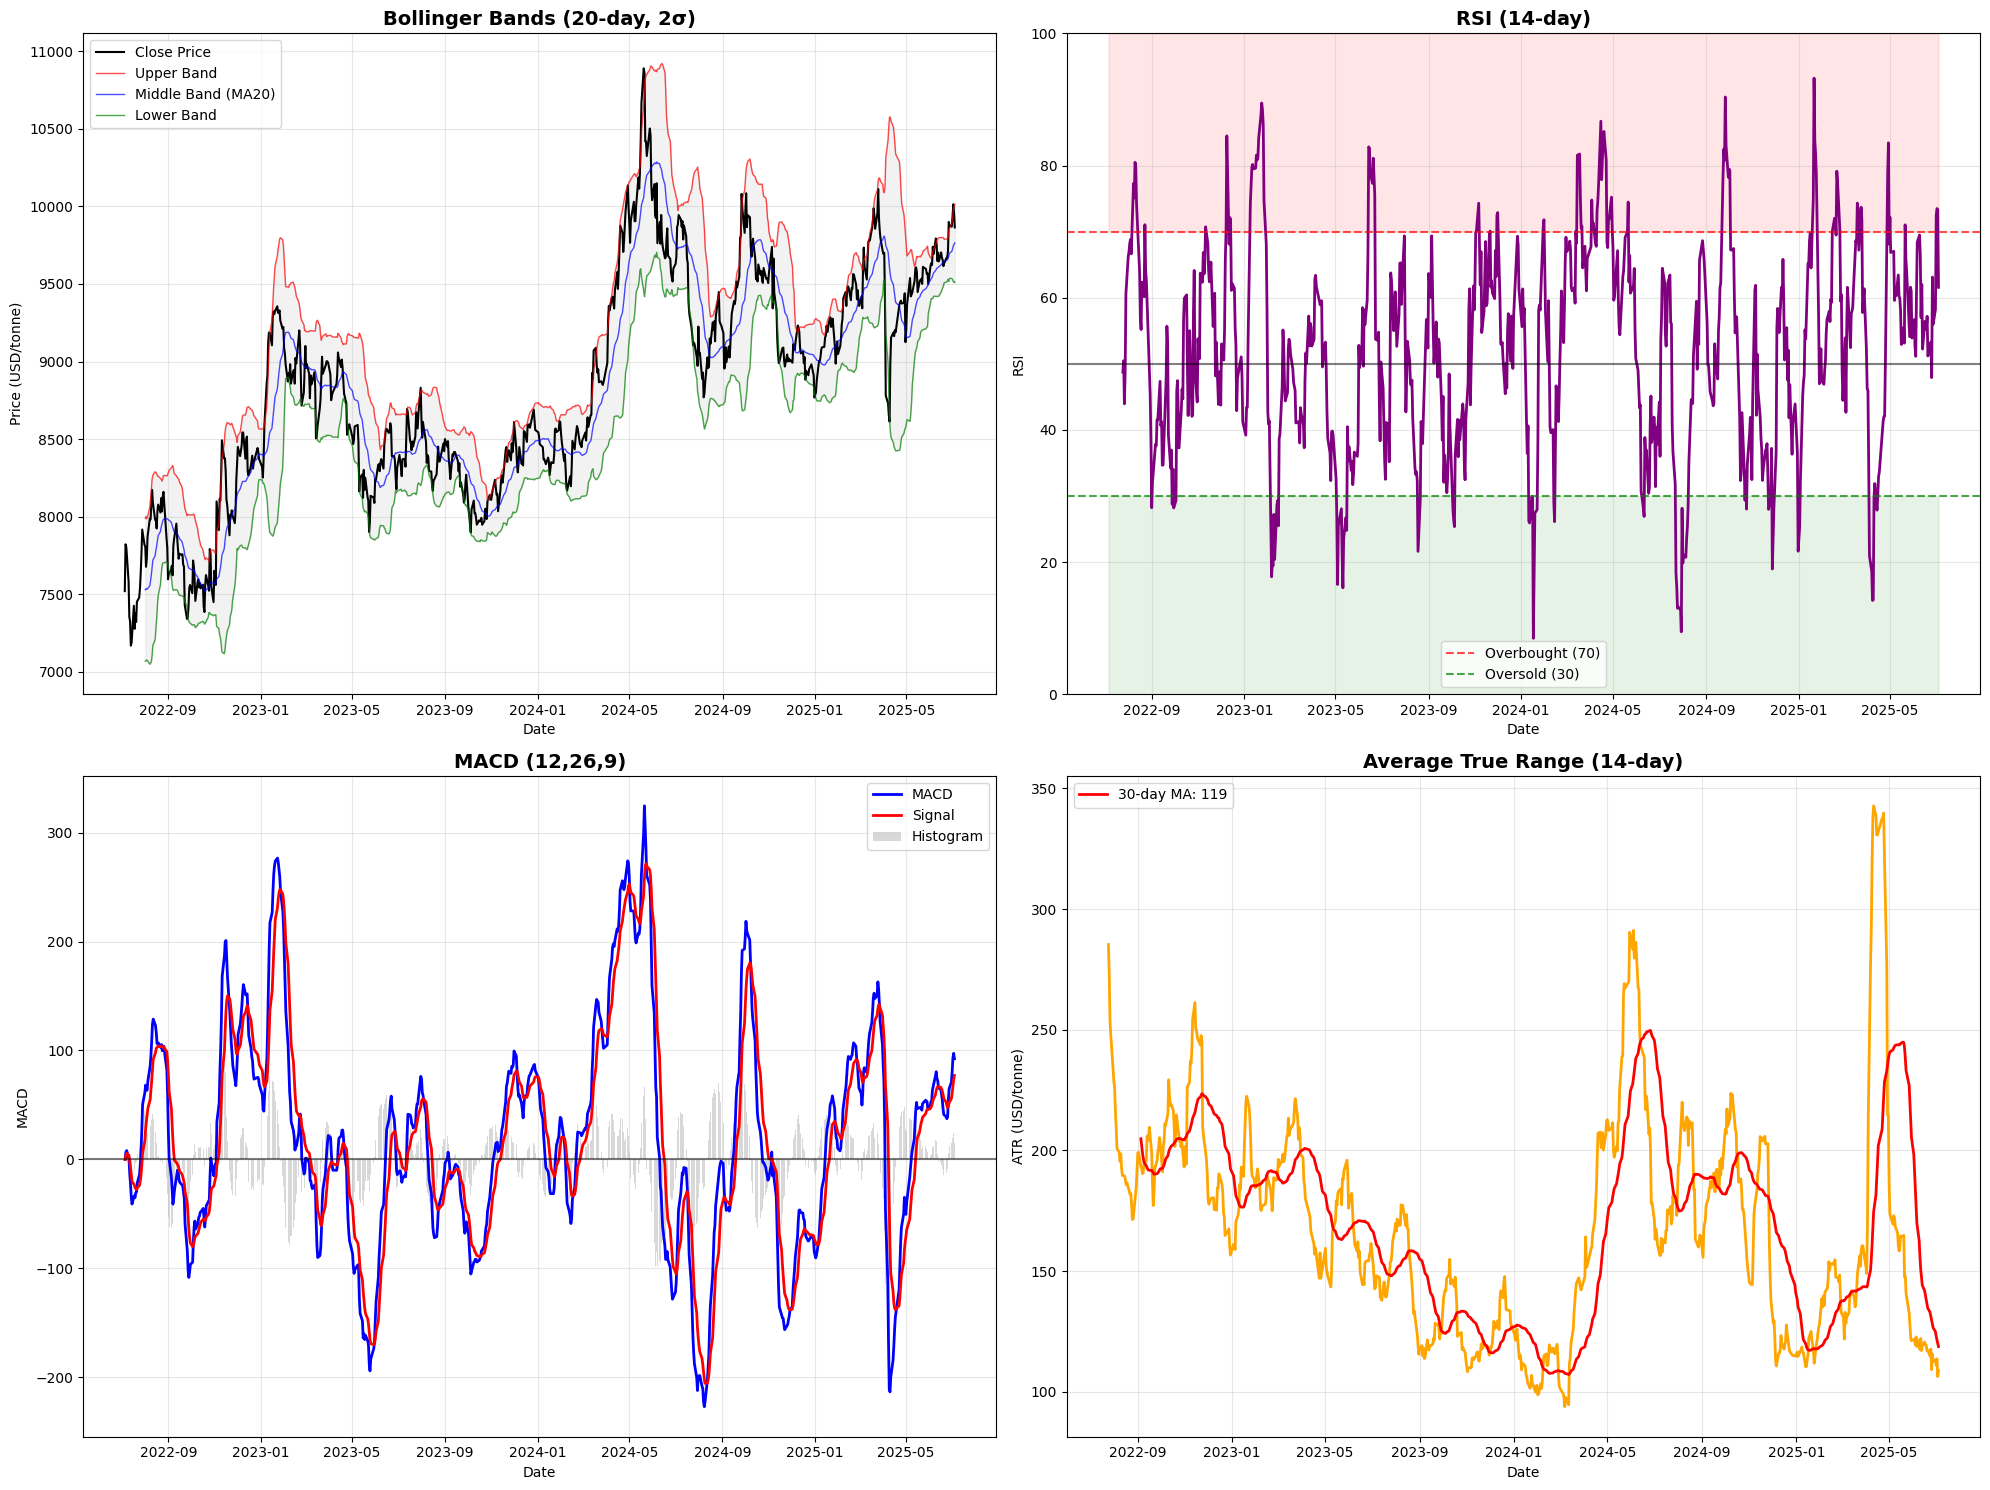


最新のテクニカル指標:
RSI: 61.6
MACD: 92.38
MACD Signal: 77.08
ATR: $109
ボリンジャーバンド幅: 5.1%

ボリンジャーバンド位置: バンド内 (正常範囲)
RSI シグナル: 中立


In [5]:
# テクニカル指標の計算
def calculate_rsi(prices, period=14):
    """RSI計算"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(prices, fast=12, slow=26, signal=9):
    """MACD計算"""
    ema_fast = prices.ewm(span=fast).mean()
    ema_slow = prices.ewm(span=slow).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal).mean()
    histogram = macd - signal_line
    return macd, signal_line, histogram

def calculate_atr(high, low, close, period=14):
    """ATR (Average True Range) 計算"""
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    true_range = pd.DataFrame({'tr1': tr1, 'tr2': tr2, 'tr3': tr3}).max(axis=1)
    atr = true_range.rolling(window=period).mean()
    return atr

if copper_3m is not None:
    # テクニカル指標計算
    copper_3m['rsi'] = calculate_rsi(copper_3m['close_price'])
    copper_3m['macd'], copper_3m['macd_signal'], copper_3m['macd_histogram'] = calculate_macd(copper_3m['close_price'])
    copper_3m['atr'] = calculate_atr(copper_3m['high_price'], copper_3m['low_price'], copper_3m['close_price'])
    
    # ボリンジャーバンド計算
    bb_period = 20
    bb_std = 2
    copper_3m['bb_middle'] = copper_3m['close_price'].rolling(bb_period).mean()
    bb_std_val = copper_3m['close_price'].rolling(bb_period).std()
    copper_3m['bb_upper'] = copper_3m['bb_middle'] + (bb_std_val * bb_std)
    copper_3m['bb_lower'] = copper_3m['bb_middle'] - (bb_std_val * bb_std)
    copper_3m['bb_width'] = (copper_3m['bb_upper'] - copper_3m['bb_lower']) / copper_3m['bb_middle'] * 100
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. ボリンジャーバンド
    ax1.plot(copper_3m.index, copper_3m['close_price'], label='Close Price', 
             linewidth=1.5, color='black')
    ax1.plot(copper_3m.index, copper_3m['bb_upper'], label='Upper Band', 
             linewidth=1, color='red', alpha=0.7)
    ax1.plot(copper_3m.index, copper_3m['bb_middle'], label='Middle Band (MA20)', 
             linewidth=1, color='blue', alpha=0.7)
    ax1.plot(copper_3m.index, copper_3m['bb_lower'], label='Lower Band', 
             linewidth=1, color='green', alpha=0.7)
    
    # バンド間を塗りつぶし
    ax1.fill_between(copper_3m.index, copper_3m['bb_upper'], copper_3m['bb_lower'], 
                     alpha=0.1, color='gray')
    
    ax1.set_title('Bollinger Bands (20-day, 2σ)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price (USD/tonne)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. RSI
    ax2.plot(copper_3m.index, copper_3m['rsi'], linewidth=2, color='purple')
    ax2.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
    ax2.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
    ax2.axhline(y=50, color='black', linestyle='-', alpha=0.5)
    ax2.fill_between(copper_3m.index, 70, 100, alpha=0.1, color='red')
    ax2.fill_between(copper_3m.index, 0, 30, alpha=0.1, color='green')
    
    ax2.set_title('RSI (14-day)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. MACD
    ax3.plot(copper_3m.index, copper_3m['macd'], label='MACD', linewidth=2, color='blue')
    ax3.plot(copper_3m.index, copper_3m['macd_signal'], label='Signal', linewidth=2, color='red')
    ax3.bar(copper_3m.index, copper_3m['macd_histogram'], label='Histogram', 
            alpha=0.3, color='gray', width=1)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    ax3.set_title('MACD (12,26,9)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('MACD')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. ATR (価格変動性)
    ax4.plot(copper_3m.index, copper_3m['atr'], linewidth=2, color='orange')
    ax4.set_title('Average True Range (14-day)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('ATR (USD/tonne)')
    ax4.grid(True, alpha=0.3)
    
    # ATR移動平均
    atr_ma = copper_3m['atr'].rolling(30).mean()
    ax4.plot(copper_3m.index, atr_ma, color='red', linewidth=2, 
             label=f'30-day MA: {atr_ma.iloc[-1]:.0f}')
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig('../generated_images/lme_3m_technical_indicators.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # テクニカル指標サマリー
    latest_data = copper_3m.iloc[-1]
    print("\n最新のテクニカル指標:")
    print("=" * 40)
    print(f"RSI: {latest_data['rsi']:.1f}")
    print(f"MACD: {latest_data['macd']:.2f}")
    print(f"MACD Signal: {latest_data['macd_signal']:.2f}")
    print(f"ATR: ${latest_data['atr']:.0f}")
    print(f"ボリンジャーバンド幅: {latest_data['bb_width']:.1f}%")
    
    # 現在の価格位置
    if latest_data['close_price'] > latest_data['bb_upper']:
        bb_position = "上限突破 (買われすぎ可能性)"
    elif latest_data['close_price'] < latest_data['bb_lower']:
        bb_position = "下限突破 (売られすぎ可能性)"
    else:
        bb_position = "バンド内 (正常範囲)"
    
    print(f"\nボリンジャーバンド位置: {bb_position}")
    
    if latest_data['rsi'] > 70:
        rsi_signal = "買われすぎ"
    elif latest_data['rsi'] < 30:
        rsi_signal = "売られすぎ"
    else:
        rsi_signal = "中立"
    
    print(f"RSI シグナル: {rsi_signal}")

## 4. 季節性・周期性分析

### 解釈ガイド:
- **月別パフォーマンス**: 特定月の価格傾向
- **曜日効果**: 週内での価格パターン
- **年間パターン**: 季節的な需給変化
- **カレンダー効果**: 休日・決算期の影響

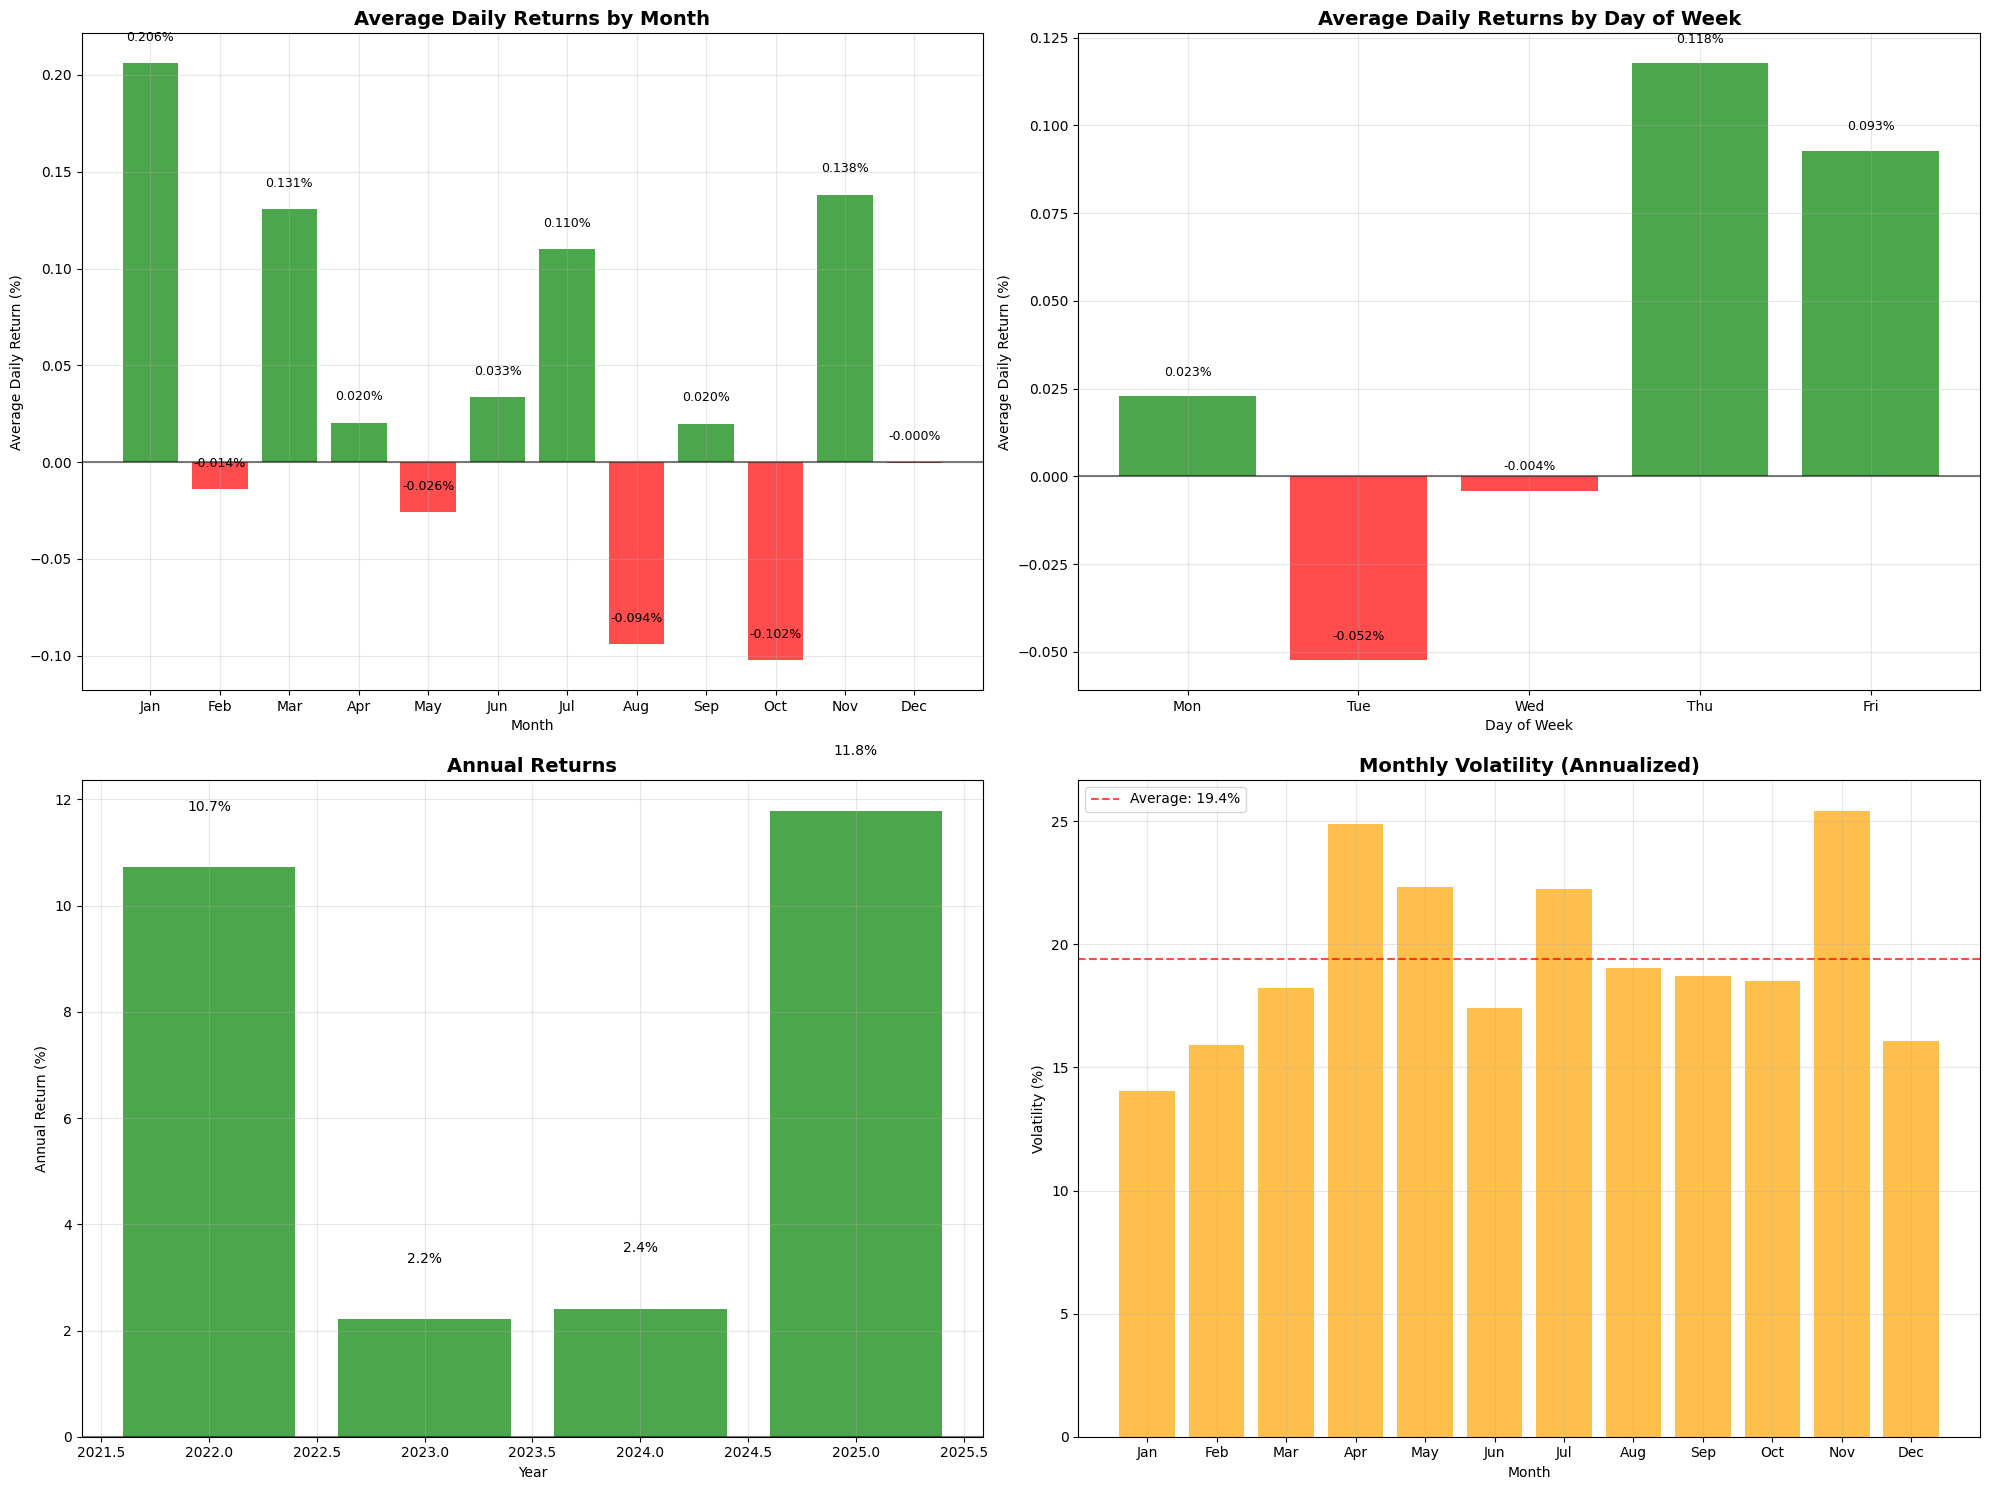


季節性分析サマリー:
最良の月: Jan (0.206%)
最悪の月: Oct (-0.102%)
最良の曜日: Thu (0.118%)
最悪の曜日: Tue (-0.052%)
最高ボラティリティ月: Nov (25.4%)
最低ボラティリティ月: Jan (14.0%)


In [6]:
# 季節性分析
if copper_3m is not None:
    # 日付関連の特徴量作成
    copper_3m['month'] = copper_3m.index.month
    copper_3m['day_of_week'] = copper_3m.index.dayofweek  # 0=Monday, 6=Sunday
    copper_3m['quarter'] = copper_3m.index.quarter
    copper_3m['year'] = copper_3m.index.year
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))
    
    # 1. 月別平均リターン
    monthly_returns = copper_3m.groupby('month')['daily_return'].mean() * 100
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    colors = ['green' if x > 0 else 'red' for x in monthly_returns]
    bars1 = ax1.bar(range(1, 13), monthly_returns, color=colors, alpha=0.7)
    ax1.set_title('Average Daily Returns by Month', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Average Daily Return (%)')
    ax1.set_xticks(range(1, 13))
    ax1.set_xticklabels(month_names)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax1.grid(True, alpha=0.3)
    
    # 値ラベル追加
    for bar, ret in zip(bars1, monthly_returns):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                 f'{ret:.3f}%', ha='center', va='bottom', fontsize=9)
    
    # 2. 曜日別平均リターン
    daily_returns = copper_3m.groupby('day_of_week')['daily_return'].mean() * 100
    day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
    
    colors2 = ['green' if x > 0 else 'red' for x in daily_returns]
    bars2 = ax2.bar(range(5), daily_returns, color=colors2, alpha=0.7)
    ax2.set_title('Average Daily Returns by Day of Week', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Day of Week')
    ax2.set_ylabel('Average Daily Return (%)')
    ax2.set_xticks(range(5))
    ax2.set_xticklabels(day_names)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.grid(True, alpha=0.3)
    
    # 値ラベル追加
    for bar, ret in zip(bars2, daily_returns):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
                 f'{ret:.3f}%', ha='center', va='bottom', fontsize=9)
    
    # 3. 年別パフォーマンス
    yearly_returns = copper_3m.groupby('year')['daily_return'].sum() * 100
    colors3 = ['green' if x > 0 else 'red' for x in yearly_returns]
    bars3 = ax3.bar(yearly_returns.index, yearly_returns, color=colors3, alpha=0.7)
    ax3.set_title('Annual Returns', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Annual Return (%)')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax3.grid(True, alpha=0.3)
    
    # 値ラベル追加
    for bar, ret in zip(bars3, yearly_returns):
        ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                 f'{ret:.1f}%', ha='center', va='bottom', fontsize=10)
    
    # 4. 月別ボラティリティ
    monthly_vol = copper_3m.groupby('month')['daily_return'].std() * np.sqrt(252) * 100
    
    ax4.bar(range(1, 13), monthly_vol, color='orange', alpha=0.7)
    ax4.set_title('Monthly Volatility (Annualized)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Month')
    ax4.set_ylabel('Volatility (%)')
    ax4.set_xticks(range(1, 13))
    ax4.set_xticklabels(month_names)
    ax4.grid(True, alpha=0.3)
    
    # 平均ボラティリティライン
    avg_monthly_vol = monthly_vol.mean()
    ax4.axhline(y=avg_monthly_vol, color='red', linestyle='--', alpha=0.7, 
                label=f'Average: {avg_monthly_vol:.1f}%')
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig('../generated_images/lme_3m_seasonality.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 季節性サマリー
    print("\n季節性分析サマリー:")
    print("=" * 50)
    
    best_month = monthly_returns.idxmax()
    worst_month = monthly_returns.idxmin()
    print(f"最良の月: {month_names[best_month-1]} ({monthly_returns[best_month]:.3f}%)")
    print(f"最悪の月: {month_names[worst_month-1]} ({monthly_returns[worst_month]:.3f}%)")
    
    best_day = daily_returns.idxmax()
    worst_day = daily_returns.idxmin()
    print(f"最良の曜日: {day_names[best_day]} ({daily_returns[best_day]:.3f}%)")
    print(f"最悪の曜日: {day_names[worst_day]} ({daily_returns[worst_day]:.3f}%)")
    
    high_vol_month = monthly_vol.idxmax()
    low_vol_month = monthly_vol.idxmin()
    print(f"最高ボラティリティ月: {month_names[high_vol_month-1]} ({monthly_vol[high_vol_month]:.1f}%)")
    print(f"最低ボラティリティ月: {month_names[low_vol_month-1]} ({monthly_vol[low_vol_month]:.1f}%)")

## 5. 総合ダッシュボード・サマリー

### 投資・トレーディング戦略への含意:
1. **トレンド分析**: 長期的な価格方向性の把握
2. **ボラティリティ管理**: リスク調整ポジションサイズ
3. **テクニカルシグナル**: エントリー・エグジットタイミング
4. **季節性活用**: 月別・曜日別の戦略調整
5. **リスク管理**: VaR、ドローダウン管理

In [7]:
# 総合サマリーレポート
if copper_3m is not None:
    print("=" * 80)
    print("LME銅3Mアウトライト 総合分析レポート")
    print("=" * 80)
    
    latest = copper_3m.iloc[-1]
    first = copper_3m.iloc[0]
    
    print(f"\n【基本情報】")
    print(f"分析期間: {copper_3m.index.min().date()} ～ {copper_3m.index.max().date()}")
    print(f"データ数: {len(copper_3m):,}日")
    print(f"最新価格: ${latest['close_price']:,.2f}/tonne")
    print(f"期間変化: {((latest['close_price'] / first['close_price']) - 1) * 100:.1f}%")
    
    print(f"\n【価格統計】")
    print(f"平均価格: ${copper_3m['close_price'].mean():,.2f}")
    print(f"最高価格: ${copper_3m['high_price'].max():,.2f} ({copper_3m['high_price'].idxmax().date()})")
    print(f"最安価格: ${copper_3m['low_price'].min():,.2f} ({copper_3m['low_price'].idxmin().date()})")
    print(f"価格レンジ: ${copper_3m['high_price'].max() - copper_3m['low_price'].min():,.2f}")
    
    print(f"\n【リスク・リターン】")
    annual_return = copper_3m['daily_return'].mean() * 252 * 100
    annual_vol = copper_3m['daily_return'].std() * np.sqrt(252) * 100
    sharpe = annual_return / annual_vol if annual_vol != 0 else 0
    
    print(f"年率リターン: {annual_return:.2f}%")
    print(f"年率ボラティリティ: {annual_vol:.2f}%")
    print(f"シャープレシオ: {sharpe:.3f}")
    print(f"最大ドローダウン: {((copper_3m['cumulative_return'].expanding().max() - copper_3m['cumulative_return']).max() * 100):.2f}%")
    print(f"勝率: {(copper_3m['daily_return'] > 0).mean() * 100:.1f}%")
    
    print(f"\n【出来高分析】")
    print(f"平均出来高: {copper_3m['volume'].mean():,.0f}ロット")
    print(f"最大出来高: {copper_3m['volume'].max():,.0f}ロット ({copper_3m['volume'].idxmax().date()})")
    print(f"価格・出来高相関: {copper_3m['close_price'].corr(copper_3m['volume']):.3f}")
    
    print(f"\n【テクニカル指標 (最新)】")
    print(f"RSI (14): {latest['rsi']:.1f}")
    print(f"MACD: {latest['macd']:.2f}")
    print(f"ATR (14): ${latest['atr']:.0f}")
    print(f"30日ボラティリティ: {latest['volatility_30d']*100:.1f}%")
    
    # 現在の市場状況判定
    print(f"\n【市場状況判定】")
    
    # トレンド判定
    if latest['close_price'] > latest['ma_200']:
        long_trend = "上昇トレンド"
    else:
        long_trend = "下降トレンド"
    
    if latest['close_price'] > latest['ma_50']:
        medium_trend = "上昇"
    else:
        medium_trend = "下降"
    
    print(f"長期トレンド (200日): {long_trend}")
    print(f"中期トレンド (50日): {medium_trend}")
    
    # ボラティリティ状況
    current_vol = latest['volatility_30d'] * 100
    avg_vol = copper_3m['volatility_30d'].mean() * 100
    
    if current_vol > avg_vol * 1.2:
        vol_status = "高ボラティリティ (注意)"
    elif current_vol < avg_vol * 0.8:
        vol_status = "低ボラティリティ (安定)"
    else:
        vol_status = "通常ボラティリティ"
    
    print(f"ボラティリティ状況: {vol_status}")
    
    # RSIシグナル
    if latest['rsi'] > 70:
        rsi_signal = "買われすぎ (売り検討)"
    elif latest['rsi'] < 30:
        rsi_signal = "売られすぎ (買い検討)"
    else:
        rsi_signal = "中立"
    
    print(f"RSIシグナル: {rsi_signal}")
    
    print(f"\n【トレーディング推奨事項】")
    print("1. ポジションサイズ: 現在のATRベースで調整")
    print(f"   - 推奨リスク1%時のポジション: {10000 / latest['atr']:.1f}ロット (1万ドル資金時)")
    print("2. ストップロス: ATRの1.5-2倍 (約${:.0f})を推奨".format(latest['atr'] * 1.5))
    print("3. 利食い目標: ATRの2-3倍 (約${:.0f})を推奨".format(latest['atr'] * 2.5))
    
    if latest['rsi'] > 70 and latest['close_price'] > latest['bb_upper']:
        print("4. 戦略: 短期的な売りバイアス (複数指標で買われすぎ)")
    elif latest['rsi'] < 30 and latest['close_price'] < latest['bb_lower']:
        print("4. 戦略: 短期的な買いバイアス (複数指標で売られすぎ)")
    else:
        print("4. 戦略: トレンドフォロー戦略を推奨")
    
    print(f"\n{'='*80}")
    print("分析完了: LME銅3Mアウトライトの包括的な市場理解を提供")
    print(f"{'='*80}")

LME銅3Mアウトライト 総合分析レポート

【基本情報】
分析期間: 2022-07-06 ～ 2025-07-04
データ数: 758日
最新価格: $9,864.00/tonne
期間変化: 31.2%

【価格統計】
平均価格: $8,821.82
最高価格: $11,104.50 (2024-05-20)
最安価格: $6,955.00 (2022-07-15)
価格レンジ: $4,149.50

【リスク・リターン】
年率リターン: 9.03%
年率ボラティリティ: 19.61%
シャープレシオ: 0.460
最大ドローダウン: 23.45%
勝率: 51.1%

【出来高分析】
平均出来高: 19,377ロット
最大出来高: 69,434ロット (2025-04-07)
価格・出来高相関: 0.202

【テクニカル指標 (最新)】
RSI (14): 61.6
MACD: 92.38
ATR (14): $109
30日ボラティリティ: 11.4%

【市場状況判定】
長期トレンド (200日): 上昇トレンド
中期トレンド (50日): 上昇
ボラティリティ状況: 低ボラティリティ (安定)
RSIシグナル: 中立

【トレーディング推奨事項】
1. ポジションサイズ: 現在のATRベースで調整
   - 推奨リスク1%時のポジション: 91.9ロット (1万ドル資金時)
2. ストップロス: ATRの1.5-2倍 (約$163)を推奨
3. 利食い目標: ATRの2-3倍 (約$272)を推奨
4. 戦略: トレンドフォロー戦略を推奨

分析完了: LME銅3Mアウトライトの包括的な市場理解を提供
